<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_10%5DCreate_a_translator_with_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_10]Create a translator with Transformer

## 1. Import 및 라이브러리 다운로드

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [2]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece as spm
import re
import os
import io
import time
import random
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  
import seaborn # Attention 시각화를 위해 필요!
plt.rc('font', family='NanumBarunGothic')
print(tf.__version__)

2.9.2


## 2. 데이터 다운로드

In [4]:
path_train_ko = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/transformer_translator/korean-english-park.train.ko'
path_train_en = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/transformer_translator/korean-english-park.train.en'

In [5]:
# with open(path_train_ko, "r") as f:
#     raw_ko = f.read().splitlines()

# print("Data Size:", len(raw_ko))
# print("Example:")

# for sen in raw_ko[0:100][::20]: print(">>", sen)

In [6]:
# with open(path_train_en, "r") as f:
#     raw_en = f.read().splitlines()

# print("Data Size:", len(raw_en))
# print("Example:")

# for sen in raw_en[0:100][::20]: print(">>", sen)

## 3. 데이터 정제 및 토큰화

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
<br><br>

2. 정제 함수를 아래 조건을 만족하게 정의하세요.
  - 모든 입력을 소문자로 변환합니다.
  - 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
  - 문장부호 양옆에 공백을 추가합니다.
  - 문장 앞뒤의 불필요한 공백을 제거합니다.
<br><Br>

3. 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.
  - https://github.com/google/sentencepiece
    - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
    - 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
    - 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
PAD : 0 / BOS : 1 / EOS : 2 / UNK : 3
<br><Br>

4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

### 1) set 데이터형으로 변환

In [7]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(path_train_ko, path_train_en)

In [8]:
# cleaned_corpus = list(set(zip(raw_ko, raw_en)))

In [9]:
len(cleaned_corpus)

78968

In [10]:
for pair in cleaned_corpus[:10]:
    print(pair)
    print('pair 0 :',pair[0])
    print('pair 1 :',pair[1])

('라니에리 감독은 “카모라네시가 물러날 때까지 조직력은 살아있었다”며 “후반전에는 경기가 전혀 안 풀렸다”고 덧붙였다.', 'In the second half, we had trouble.')
pair 0 : 라니에리 감독은 “카모라네시가 물러날 때까지 조직력은 살아있었다”며 “후반전에는 경기가 전혀 안 풀렸다”고 덧붙였다.
pair 1 : In the second half, we had trouble.
('원문기사', 'The body of a fourth person')
pair 0 : 원문기사
pair 1 : The body of a fourth person
('경제학자들과 제조업체들은 세계적으로 밀 가격이 인상돼 파스타 가격이 인상됐다고 말했다.', 'The increase in pasta prices is being driven by rising wheat prices worldwide, economists and producers say.')
pair 0 : 경제학자들과 제조업체들은 세계적으로 밀 가격이 인상돼 파스타 가격이 인상됐다고 말했다.
pair 1 : The increase in pasta prices is being driven by rising wheat prices worldwide, economists and producers say.
('짐 맥테비아 금융구조조정 컨설턴트는 합병 이전 크라이슬러는 불확실한 위치에 서 있었다고 전했다.', 'Jim McTevia, a Detroit restructuring consultant, said Chrysler was in a precarious position before the deal. "I really believe that had this not taken place, Chrysler would have ultimately been sold off in pieces," he said.')
pair 0 : 짐 맥테비아 금융구조조정 컨설턴트는 합병 이전 크라이슬러는 불확실한 위치에 서 있

### 2) 데이터 정제

In [11]:
def preprocess_sentence(sentence, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

### 3) SentencePiece

In [12]:
eng_corpus = []
kor_corpus = []

#num_examples = 20000

for pair in cleaned_corpus:#[:num_examples]:
    kor_corpus.append(preprocess_sentence(pair[0]))
    eng_corpus.append(preprocess_sentence(pair[1]))

print("한국어:", kor_corpus[100])   # go away !
print("영어:", eng_corpus[100])

한국어: 이 변화는 현재의 체계가 항공사들의 재정에 너무 심하게 세금을 물리고 있다는 항공사들의 불만에 대한 답이다 .
영어: the change is in response to airline complaints that the current system taxes their finances too heavily .


- https://paul-hyun.github.io/vocab-with-sentencepiece/
- https://www.programcreek.com/python/example/117288/sentencepiece.SentencePieceProcessor

In [13]:
def generate_tokenizer(corpus, Mtype, vocab_size, ko_en):
  temp_file = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/transformer_translator/ratings_train_{}.txt.temp'.format(ko_en)
  model_prefix = 'spm_{}'.format(ko_en)
  with open(temp_file, 'w') as f:
      for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
          f.write(str(row) + '\n')

  if Mtype == 'bpe' or Mtype == 'unigram' or Mtype == 'char'or Mtype == 'word':
    spm.SentencePieceTrainer.Train(
        f"--input={temp_file} --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type={Mtype}"+
        " --pad_id=0 --pad_piece=[PAD]" + 
        " --unk_id=1 --unk_piece=[UNK]" + 
        " --bos_id=2 --bos_piece=[BOS]" + 
        " --eos_id=3 --eos_piece=[EOS]".format(temp_file, model_prefix, vocab_size, Mtype)    
    )
  else:
    print("Mtype를 잘 못 입력 했습니다 'bpe', 'unigram', 'char', 'word' 중 하나를 입력해주세요")
    if __name__ == "__main__": # 참조 : https://www.delftstack.com/ko/howto/python/python-exit-if-statement/
      load_data(0)  
      print("Broken out")
  
  #위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

  s = spm.SentencePieceProcessor()
  s.Load(model_prefix+'.model')
  if model_prefix == 'spm_en':
    s.set_encode_extra_options("bos:eos")

  return s

In [14]:
ko_tokenizer = generate_tokenizer(kor_corpus, 'unigram', 20000, 'ko')
en_tokenizer = generate_tokenizer(eng_corpus, 'unigram', 20000, 'en')
# SP_model_train('bpe', 8000)
# SP_model_train('char', 8000)
# SP_model_train('word', 8000)
# SP_model_train('char', 16000)

In [15]:
!ls -l spm_ko*

-rw-r--r-- 1 root root 623747 Oct 14 03:01 spm_ko.model
-rw-r--r-- 1 root root 403547 Oct 14 03:01 spm_ko.vocab


In [16]:
!ls -l spm_en*

-rw-r--r-- 1 root root 575645 Oct 14 03:02 spm_en.model
-rw-r--r-- 1 root root 355536 Oct 14 03:02 spm_en.vocab


### 4) 토큰화
- https://lsjsj92.tistory.com/600
- https://wikidocs.net/86657

In [17]:
src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
        ko_pair = ko_tokenizer.encode_as_ids(kor_corpus[idx])
        en_pair = en_tokenizer.encode_as_ids(eng_corpus[idx])
        if len(ko_pair) <= 50 and len(en_pair) <= 50: # 영어는 52로 지정한 이유는 eos, bos가 추가되었기 때문이다.
            src_corpus.append(ko_pair)
            tgt_corpus.append(en_pair)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [18]:
# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_test, dec_train, dec_test = \
train_test_split(enc_train, dec_train, test_size=0.2)

enc_train_size = len(enc_train)
dec_train_size = len(dec_train)
enc_test_size = len(enc_test)
dec_test_size = len(dec_test)
print("한국어 train Size:", enc_train_size)
print("영어 train Size:", dec_train_size)
print("한국어 test Size:", enc_test_size)
print("영어 test Size:", dec_test_size)
print('한국어 shape : ', enc_train.shape)
print('영어 shape : ', dec_train.shape)


한국어 train Size: 57714
영어 train Size: 57714
한국어 test Size: 14429
영어 test Size: 14429
한국어 shape :  (57714, 50)
영어 shape :  (57714, 50)


In [19]:
# src_corpus = []
# tgt_corpus = []

# num_examples = 20000

# for pair in cleaned_corpus[:num_examples]:
#     ko_pair = ko_tokenizer.encode_as_pieces(pair[0])
#     en_pair = en_tokenizer.encode_as_pieces(pair[1])
#     if len(ko_pair) >= 50 or len(en_pair) >= 52:
#         src_corpus.append(ko_pair)
#         tgt_corpus.append(en_pair)

# print("한국어:", src_corpus[100])   # go away !
# print("영어:", tgt_corpus[100])

In [20]:
# def tokenize(corpus):
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
#     tokenizer.fit_on_texts(corpus)

#     tensor = tokenizer.texts_to_sequences(corpus)

#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

#     return tensor, tokenizer

In [21]:
# # 토큰화하기
# enc_tensor, enc_tokenizer = tokenize(src_corpus)
# dec_tensor, dec_tokenizer = tokenize(tgt_corpus)

# # 훈련 데이터와 검증 데이터로 분리하기
# enc_train, enc_val, dec_train, dec_val = \
# train_test_split(enc_train, dec_train, test_size=0.2)

# print("한국어 Vocab Size:", len(enc_tokenizer.index_word))
# print("영어 Vocab Size:", len(dec_tokenizer.index_word))

## 4. 모델 설계

In [22]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [24]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
 

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [30]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

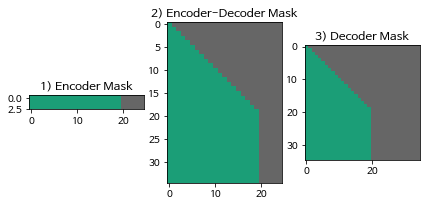

In [31]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [32]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

## 5. 훈련하기

1. 2 Layer를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)
<br><br>
2. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)
<br><br>
3. Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)
<br><br>
4. train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.
<br><br>
5. 학습을 진행합니다.
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!


### 1) 2 Layer를 가지는 Transformer를 선언
- 클래스에 대한 이해가 부족한 것 같음



In [33]:
transformer = Transformer(n_layers=2, 
                          d_model=512,
                          n_heads=8,
                          d_ff=2048,
                          src_vocab_size = enc_train_size,
                          tgt_vocab_size = dec_train_size,
                          pos_len=50,
                          dropout=0.2,
                          shared=True)

### 2) learning rate scheduler & Adam Optimizer 선언

In [34]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9,
                                     name='Adam')

### 3) Loss 함수 정의

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4) train_step 함수 정의
- optimizer.apply_gradients() 사용법
  - https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer
- 해당 오류 해결 방법 : 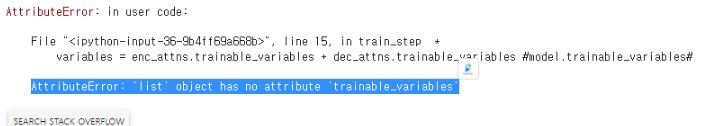 
  - https://stackoverflow.com/questions/62147370/attributeerror-model-object-has-no-attribute-trainable-variables-when-model

In [36]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    variables = model.trainable_variables#enc_attns.trainable_variables + dec_attns.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 5) 학습 진행

In [37]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [38]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [39]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [40]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s campaign , obama s campaign
Input: 시민들은 도시 속에 산다.
Predicted translation: the area were still have been a little .
Input: 커피는 필요 없다.
Predicted translation: we are not not be not because .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two people were killed in the two people were killed .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s presidential candidates .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city s cities .
Input: 커피는 필요 없다.
Predicted translation: you can be  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s presidential nominee is a presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are also seeing the city .
Input: 커피는 필요 없다.
Predicted translation: you don t want you to get your life .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very part of the obama s biggest obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the red cross is a mountain .
Input: 커피는 필요 없다.
Predicted translation: coffee is not a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll was the on the day .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a bitter partisan class .
Input: 시민들은 도시 속에 산다.
Predicted translation: the number of cities is about .
Input: 커피는 필요 없다.
Predicted translation: coffee is not at any coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll occurred at .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the way .
Input: 시민들은 도시 속에 산다.
Predicted translation: the drivers of the mountain .
Input: 커피는 필요 없다.
Predicted translation: no need to be coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths occurred when the deaths occurred .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obamas .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is cities in the cities .
Input: 커피는 필요 없다.
Predicted translation: no longer needs you knew you would you your relationship .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven death toll stood .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the biggest po class class .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is urgently available to rest in the cities .
Input: 커피는 필요 없다.
Predicted translation: no patient needs to be coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were confirmed dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the illinois senator is a new president .
Input: 시민들은 도시 속에 산다.
Predicted translation: options such as the mountain country .
Input: 커피는 필요 없다.
Predicted translation: proceeds from the coffee was taken off .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven third of seven people were killed monday .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are thought to live to the mountain gods .
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed when the seventh round sunday .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the presidential campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the option is far more than one .
Input: 커피는 필요 없다.
Predicted translation: no coffee has such a cnn .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were the highest person without the death toll stood .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president of the presidential office .
Input: 시민들은 도시 속에 산다.
Predicted translation: the option is the city of ten cities
Input: 커피는 필요 없다.
Predicted translation: no coffee has seen a child .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven fifth employees were killed monday .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first person to be obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the option of hariri is heated .
Input: 커피는 필요 없다.
Predicted translation: the coffee has taken away .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday when the nine earthquake occurred .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is locally secured one way of the city citizens .
Input: 커피는 필요 없다.
Predicted translation: the coffee has taken strength .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed with seven people monday .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: drivers , cities among cities is nearby .
Input: 커피는 필요 없다.
Predicted translation: the coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven astronauts were with seven seven seven seven seven astronauts including seven astronauts .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is celebrating a one of the cities .
Input: 커피는 필요 없다.
Predicted translation: needs to coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven fifth people were killed .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the drivers is fine for cities .
Input: 커피는 필요 없다.
Predicted translation: the coffee has taken ex coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed with seven of seventh generation commission employees .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: they put the stake in the city .
Input: 커피는 필요 없다.
Predicted translation: take on coffee such thing . coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven of seven astronauts were with the seven death toll stood at .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they travel to the mountain cities .
Input: 커피는 필요 없다.
Predicted translation: the coffee is such a cnn don t need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they normally knocked down .
Input: 커피는 필요 없다.
Predicted translation: the little need is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed .


In [42]:
for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they normally knocked down .
Input: 커피는 필요 없다.
Predicted translation: the little need is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed .


Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


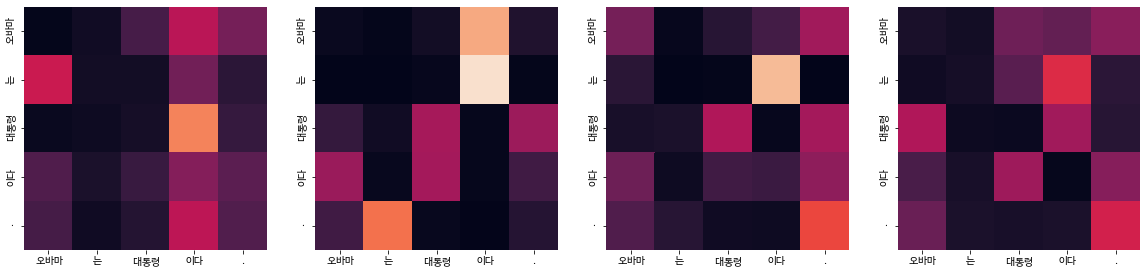

Encoder Layer 2


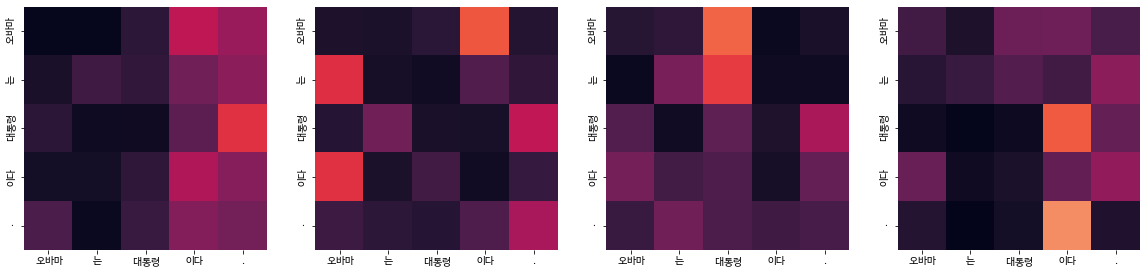

Decoder Self Layer 1


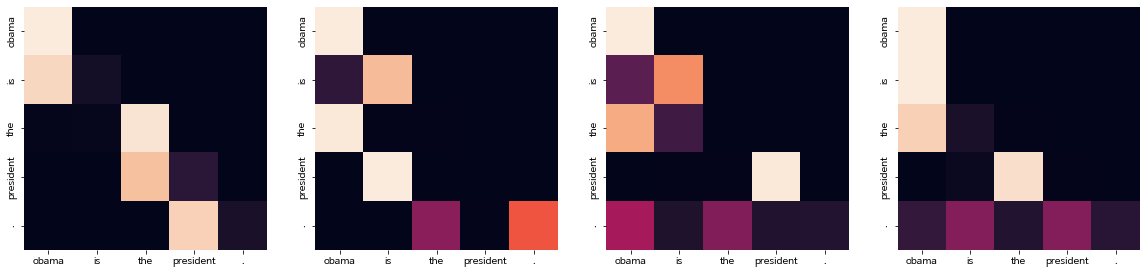

Decoder Src Layer 1


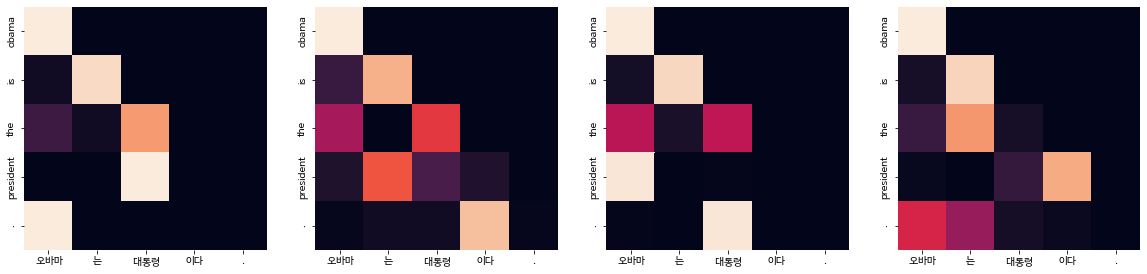

Decoder Self Layer 2


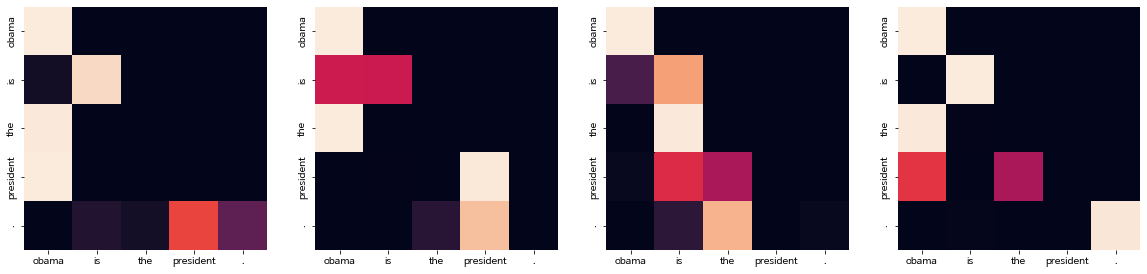

Decoder Src Layer 2


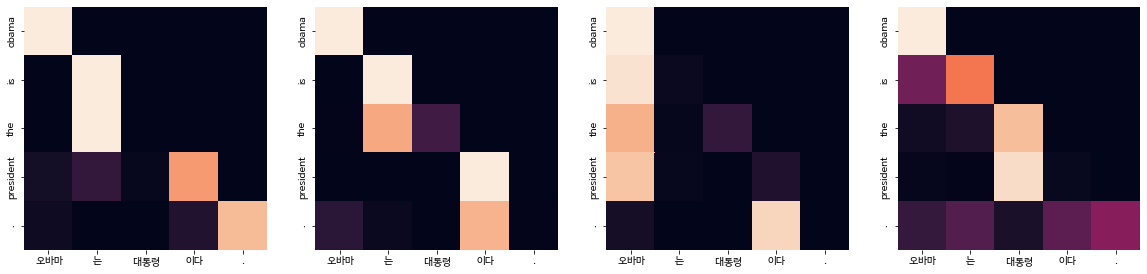

Input: 시민들은 도시 속에 산다.
Predicted translation: they normally knocked down .
Encoder Layer 1


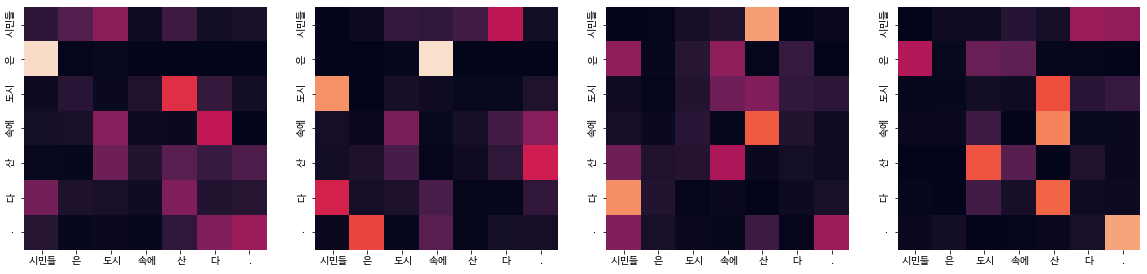

Encoder Layer 2


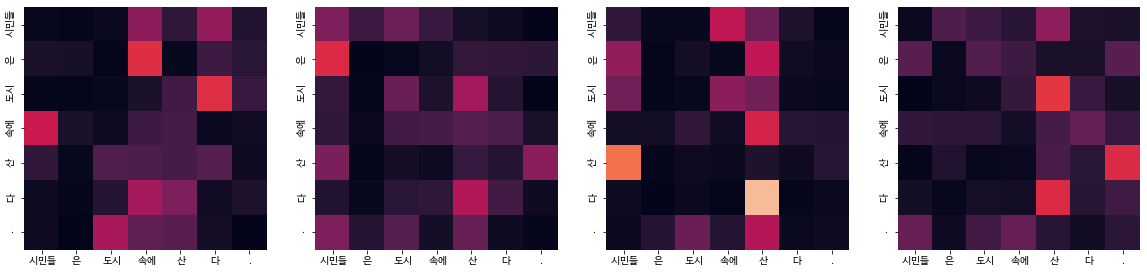

Decoder Self Layer 1


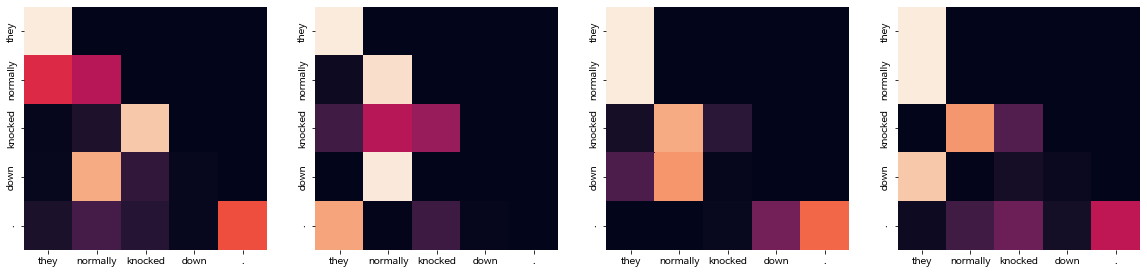

Decoder Src Layer 1


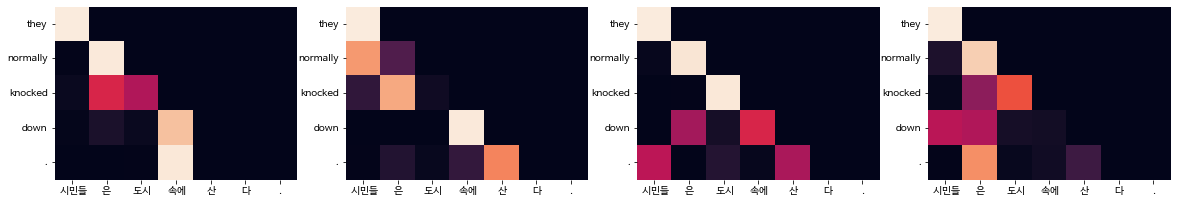

Decoder Self Layer 2


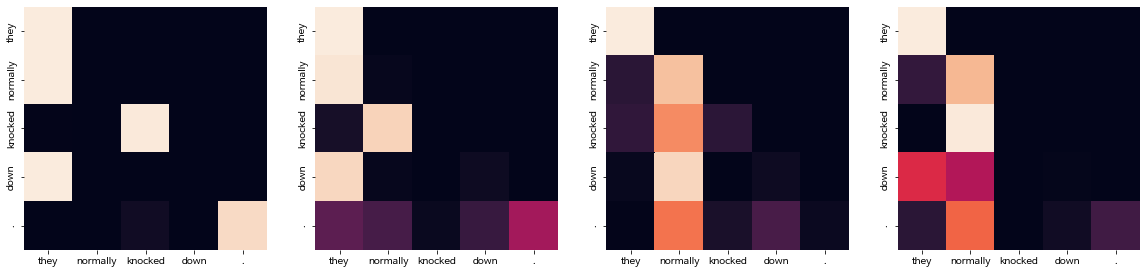

Decoder Src Layer 2


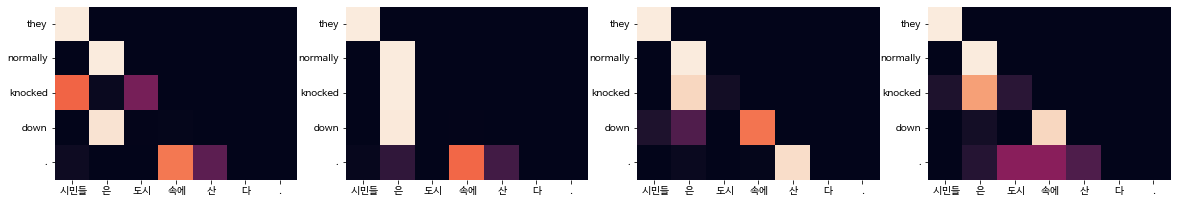

Input: 커피는 필요 없다.
Predicted translation: the little need is necessary .
Encoder Layer 1


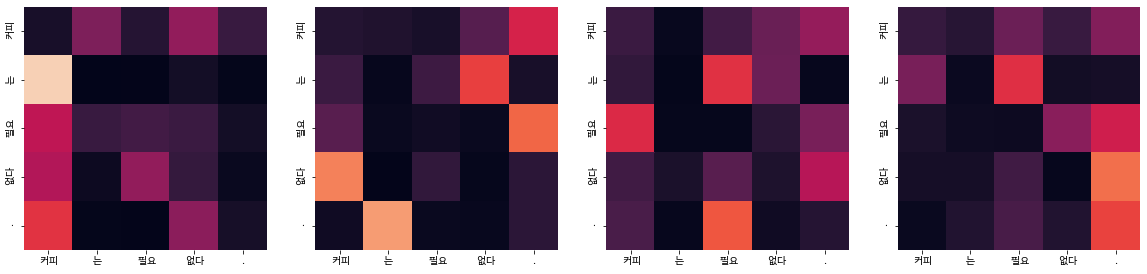

Encoder Layer 2


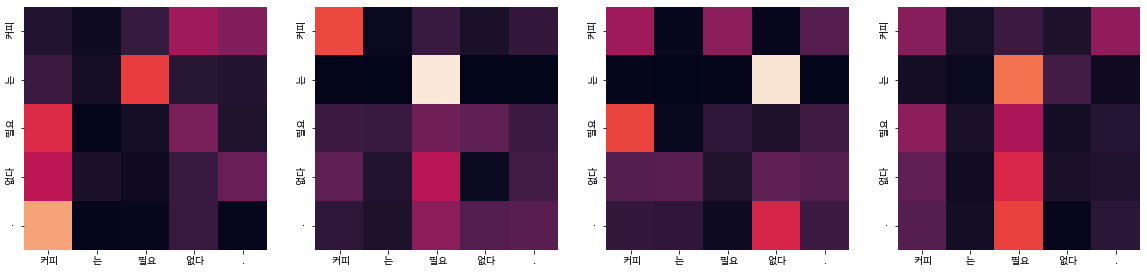

Decoder Self Layer 1


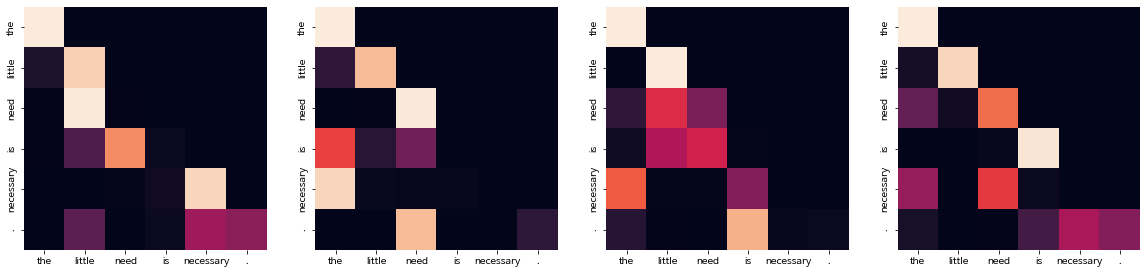

Decoder Src Layer 1


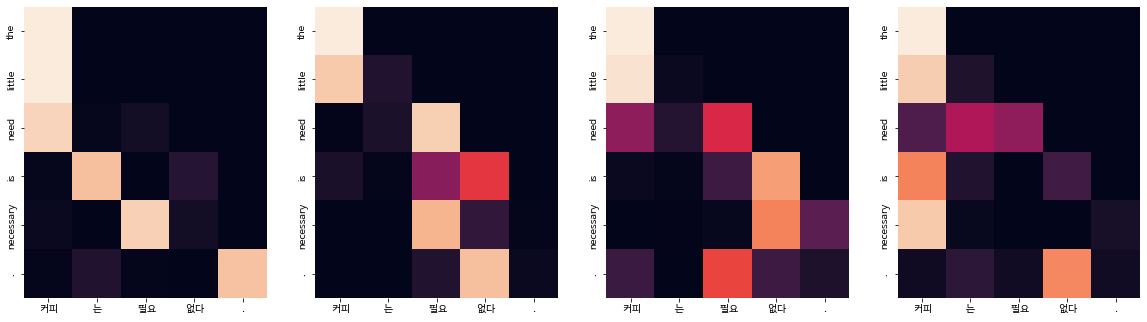

Decoder Self Layer 2


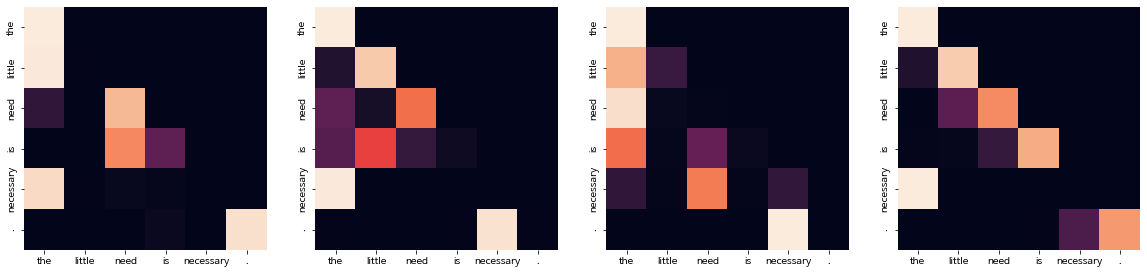

Decoder Src Layer 2


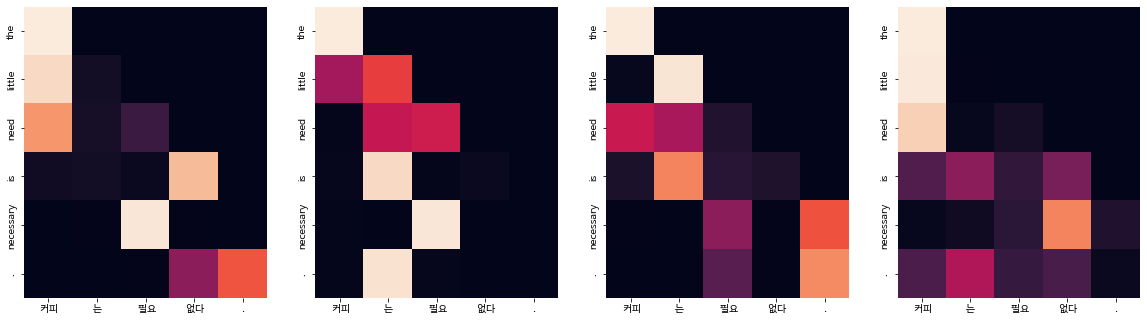

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed .
Encoder Layer 1


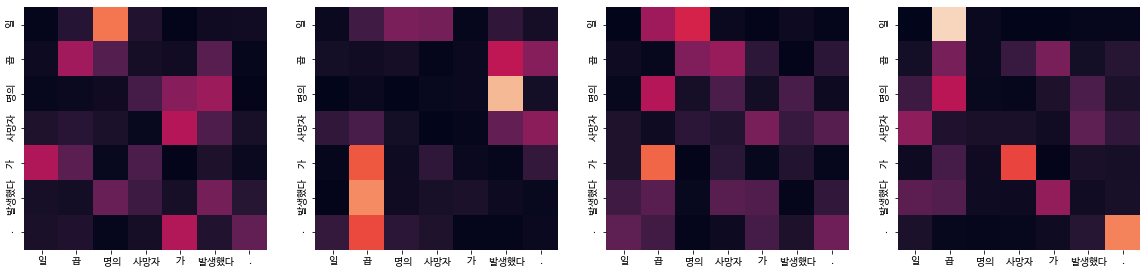

Encoder Layer 2


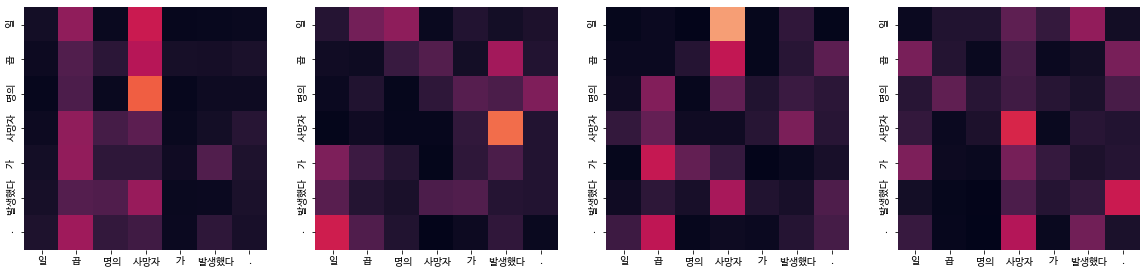

Decoder Self Layer 1


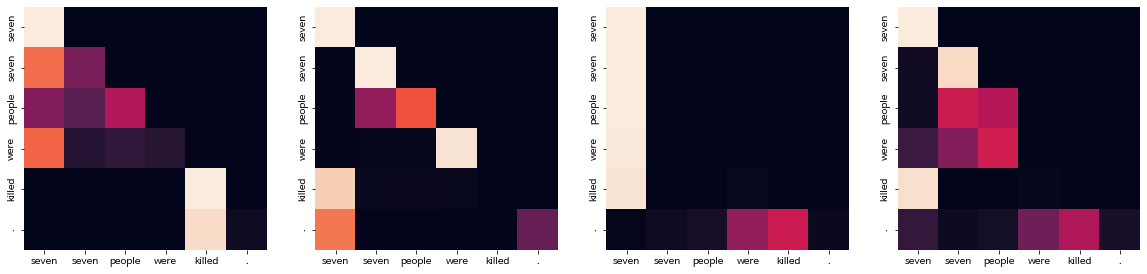

Decoder Src Layer 1


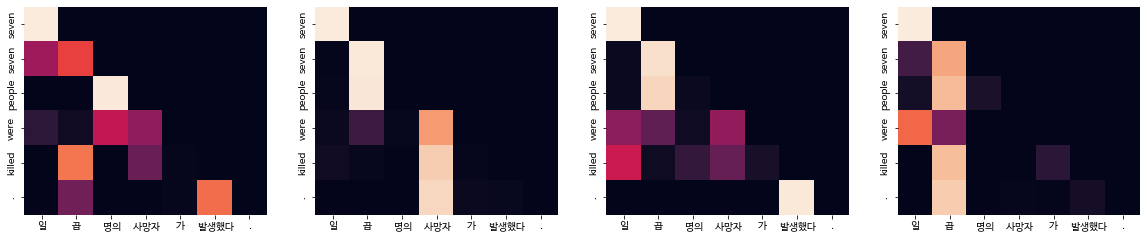

Decoder Self Layer 2


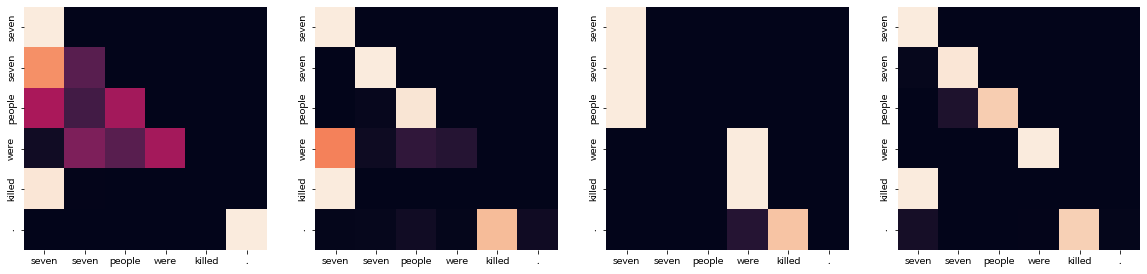

Decoder Src Layer 2


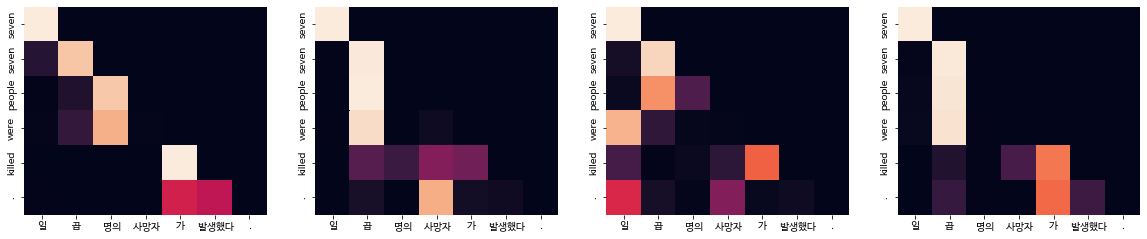

In [43]:
for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer, True)

## 6. 회고

## 7.루브릭 기준

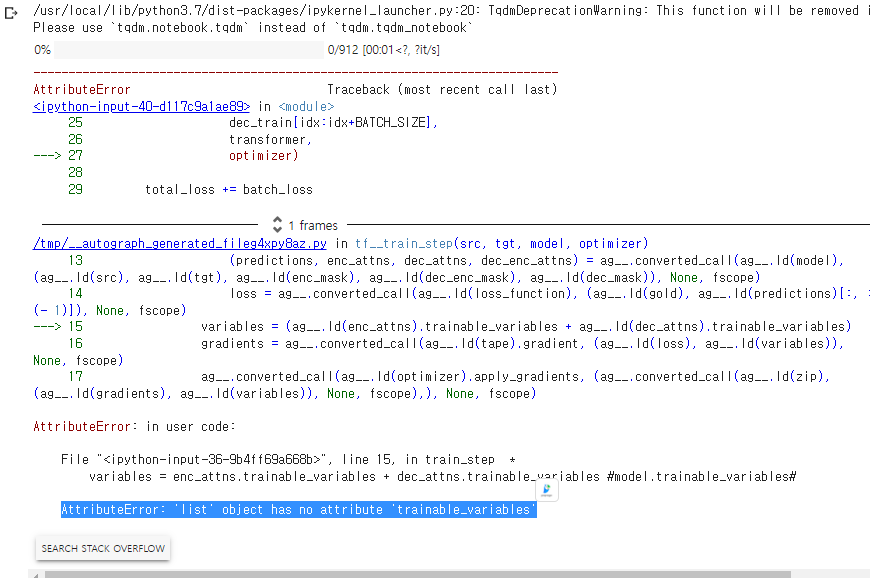

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
    - 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.

2. Transformer 번역기 모델이 정상적으로 구동된다.
    - Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
    
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.